# Figure 4: Denmark Strait freshwater transport reconstructions

This notebook will reproduce Figure 4 from  E. Boland et al. 2025 (doi to come). This requires input datafiles (expects to find them in ../data_out) to run - please see the README for details.

Please attribute any plots or code from this notebook using the DOI from Zenodo: TO COME

E Boland Jan 2025 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
import utils as ut
import xarray as xr
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [2]:
fcname='horflux_fw_denm'
rootdir='/users/emmomp/data/canari/experiments'
expt='fwd_26y'
eyears=['2000','2006','2014']
plotvars=['all_OCE','wind_OCE','adxx_qnetXEXFqnet_sum', 'adxx_empmrXEXFempmr_sum']
plotvar_labels=dict(zip(plotvars,['Total Recon','Wind Stress','Heat','Salt']))

In [3]:
fc_climanom,fc_mth=ut.get_soln(fcname,rootdir+'/'+expt)

read_llc_to_tiles: full_filename:  /users/emmomp/data/canari/experiments/fwd_26y/m_horflux_fw_denm.0000000129.data


In [4]:
YY=[]
for eyear in eyears:
    YY_year=xr.open_mfdataset(f'../data_out/denstr_fwflux_mthEVrecon_{eyear}_*.nc',combine='nested',concat_dim=None,compat='minimal').assign_coords({'eyear':eyear}).sel(time=slice('1996-01-01',None))
    YY.append(YY_year)
YY=xr.concat(YY,'eyear').load()
YY_dt=YY.to_array().copy(data=signal.detrend(YY.to_array())).to_dataset('variable')

XX=fc_climanom # detrended in utils

In [5]:
ev = (1-(XX-YY_dt).var('time')/XX.var('time')).load()
ev_mean=(1-(XX-YY_dt.mean('eyear')).var('time')/XX.var('time')).load()

In [6]:
XX_smooth=ut.butter_ufunc(XX,13,'time')
YY_smooth=ut.butter_ufunc(YY_dt,13,'time')
ev_mean_smooth=(1-(XX_smooth-YY_smooth.mean('eyear')).var('time')/XX_smooth.var('time')).load()

In [7]:
XX_high=XX-XX_smooth
YY_high=YY_dt-YY_smooth
ev_mean_high=(1-(XX_high-YY_high.mean('eyear')).var('time')/XX_high.var('time')).load()

In [9]:
XX_plot=[XX,XX_smooth,XX_high]
YY_plot=[YY_dt,YY_smooth,YY_high]
ev_plot=[ev_mean,ev_mean_smooth,ev_mean_high]
ylims=[60,35,45]
plot_labels=['peak','peaksmooth','peakhigh']

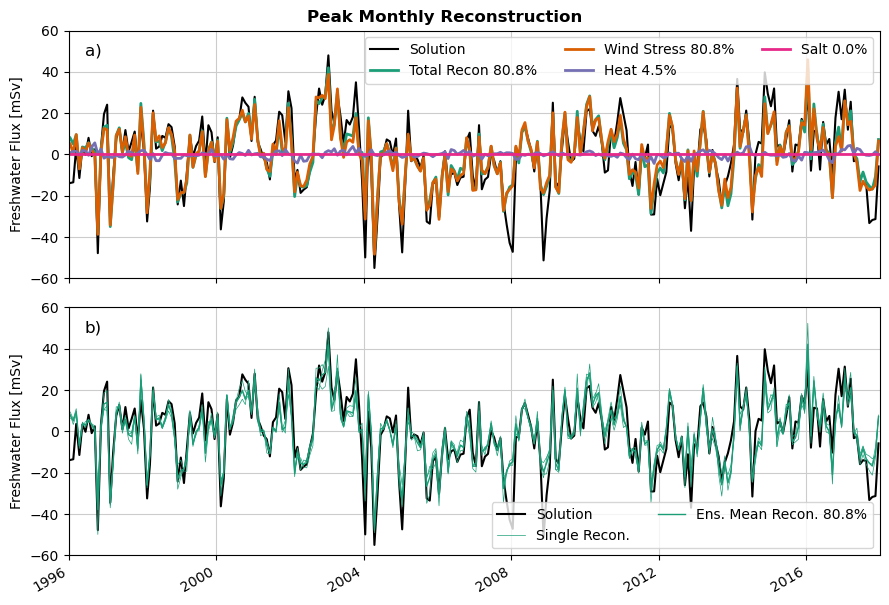

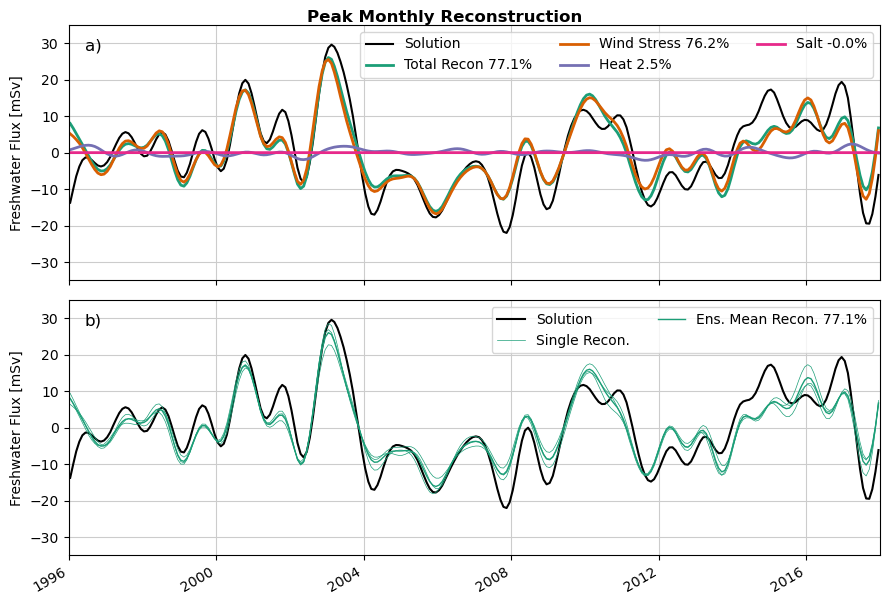

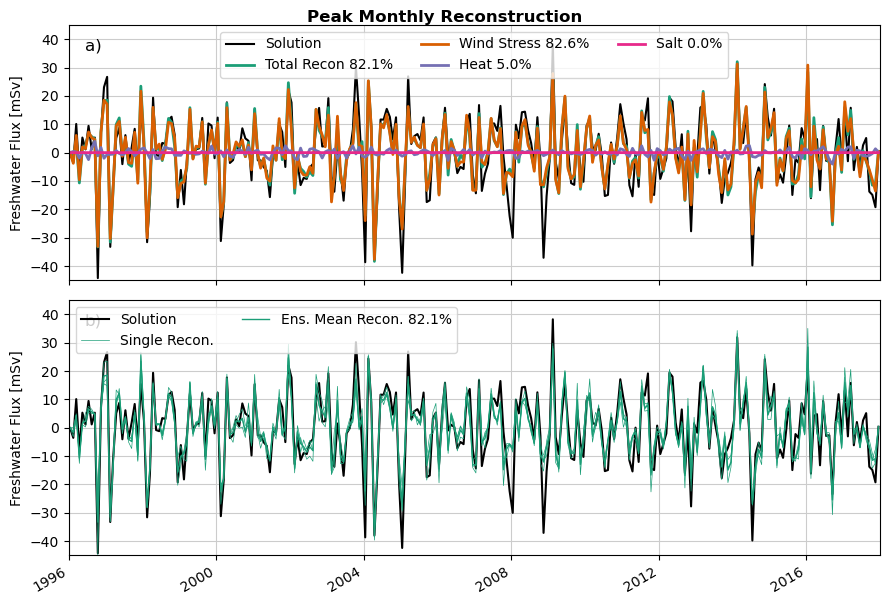

In [12]:
colors=plt.get_cmap('Dark2')
for nplot in range(0,3):

    plt.figure(figsize=[9,6])

    ax=plt.subplot(2,1,1)
    (XX_plot[nplot]/1e3).plot(color='k',label='Solution',ax=ax)
    for iv,var in enumerate(plotvars):
        (YY_plot[nplot][var]/1e3).mean('eyear').plot(linewidth=2,color=colors(iv),label=f'{plotvar_labels[var]} {ev_plot[nplot][var]*100:2.1f}%',ax=ax)
    plt.ylabel('Freshwater Flux [mSv]')
    plt.title('')
    plt.xlim([np.datetime64('1996-01-01'),np.datetime64('2017-12-31')])
    plt.grid(axis='both', color='0.8')
    plt.xlabel('')
    ax.set_xticklabels([])
    plt.ylim([-ylims[nplot],ylims[nplot]])
    plt.legend(ncol=3)
    plt.text(0.02,0.9,'a)',fontsize=12,transform=ax.transAxes)

    ax=plt.subplot(2,1,2)
    var='all_OCE'
    iv=0
    ppx=(XX_plot[nplot]/1e3).plot(color='k',label='Solution',ax=ax)
    pp1=(YY_plot[nplot][var]/1e3).plot(hue='eyear',linewidth=0.5,color=colors(iv),add_legend=False,ax=ax)
    pp2=(YY_plot[nplot][var]/1e3).mean('eyear').plot(linewidth=1,color=colors(iv),ax=ax)
    plt.ylabel('Freshwater Flux [mSv]')
    plt.title('')
    plt.xlim([np.datetime64('1996-01-01'),np.datetime64('2017-12-31')])
    plt.grid(axis='both', color='0.8')
    plt.legend([ppx[0],pp1[0],pp2[0]],['Solution','Single Recon.',f'Ens. Mean Recon. {ev_plot[nplot][var]*100:2.1f}%'],ncol=2)
    plt.xlabel('')
    plt.ylim([-ylims[nplot],ylims[nplot]])
    plt.text(0.02,0.9,'b)',fontsize=12,transform=ax.transAxes)

    plt.tight_layout()
    plt.suptitle('Peak Monthly Reconstruction',fontsize=12,fontweight='bold',y=1.0)
    plt.savefig(f'../plots/fig4_{plot_labels[nplot]}recons.pdf',bbox_inches='tight')